# 全国合成レーダーエコー強度のデータを使ってみる

降水量のデータの1つである，「全国合成レーダーエコー強度GPV」というデータを使用してみます。

[wgrib2](https://www.cpc.ncep.noaa.gov/products/wesley/wgrib2/)を用いた手法や，grib2_decを使用した手法がよく紹介されていますが，今回はgrib2ファイルを「単なるバイナリファイル」として読み込んでみたいと思います。

標準ライブラリ以外に使用するライブラリはこちら。
 - numpy
 - basemap
 - matplotlib

これらのライブラリは，

$ conda install -c conda-forge numpy basemap matplotlib

で導入することができます。

※condaのコマンドが使用できない方は[こちら](https://github.com/yellowmeteor/met_python.github.io/blob/master/install/python-install.md)。

In [1]:
# Libraries
import numpy as np
from urllib.request import urlopen, urlretrieve # ダウンロード用
from tarfile import open as tar_open
from struct import unpack # バイト値から変換
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap # 地図データの使用
from matplotlib import pyplot as plt # 描画用
from pathlib import Path # ファイル消去用

今回使用するデータは，京都大学生存圏研究所のものを使用します。

「教育研究機関向けにデータを提供しています．企業活動等のためにデータを頻繁に必要とされる方は，気象業務支援センターからデータを直接購入し，データ提供スキーム全体の維持発展にご協力ください」

と書かれているため，商用利用される方は気象データを販売しているところから購入して使用してください。

さて，今回は例として，2019年9月1日00UTCのデータを使用します。

In [2]:
# download
time = datetime(2019, 9, 1)
url = "http://database.rish.kyoto-u.ac.jp/arch/jmadata/data/jma-radar/synthetic/original/{0:04d}/{1:02d}/{2:02d}/Z__C_RJTD_{0:04d}{1:02d}{2:02d}{3:02d}{4:02d}00_RDR_JMAGPV__grib2.tar".format(time.year, time.month, time.day, time.hour, time.minute)
tar_file = "{0:04d}{1:02d}{2:02d}_{3:02d}{4:02d}.tar".format(time.year, time.month, time.day, time.hour, time.minute)
urlretrieve(url, tar_file)

('20190901_0000.tar', <http.client.HTTPMessage at 0x19873180160>)

ダウンロードを済ませたので，tarファイルの読み込みをしていきます。

tarファイルをわざわざ展開しなくても中身を読み込みできるPythonはすごいですね。

tarファイルの中にはエコー頂高度のデータもありますが，今回はエコー強度のみを選択して使用します。

そして，実際にバイナリファイルとしてファイルを読み込んでいきます。

気象庁が提供するファイルを読み込むためには，wgrib2やgrib2_decなどを使用する手もあるのですが，今回は[配信資料に関する技術情報](https://www.data.jma.go.jp/add/suishin/jyouhou/pdf/162.pdf)を見ながら読み込んでいきます。

配信資料に関する技術情報を読むと，ファイルの中身は8つの節に分かれていることがわかります。

さらにその中で何オクテット目（何バイト目）にどんな情報が含まれているのかわかります。

わかりますわかります…といっても，情報量多いしどないしたらええかわからんわ！ってのが正直なところだと思います。

そこで今回，必要な部分だけ読んでいく方法をここに示してみました。

まずはバイナリデータを0から8までの合計9の節に分けてみます。

In [3]:
# read
tar = tar_open(tar_file, 'r')
# tarファイルには2.5kmメッシュ全国合成レーダーエコー頂高度GPVも含まれているため，エコー強度のファイルを選択する
if "Ggis1km" in tar.getnames()[0]:
    i = 0
else:
    i = 1
f = tar.extractfile(tar.getmembers()[i]).read()
sec_0 = f[:16] # 第0節　16オクテット
sec_1 = f[16:37] # 第1節　21オクテット
sec_2 = f[0] # 第2節　不使用
sec_3 = f[37:109] # 第3節　72オクテット
sec_4 = f[109:191] # 第4節　82オクテット
sec_5 = f[191:710] # 第5節　519オクテット
sec_6 = f[710:716] # 第6節　6オクテット
sec_7 = f[716:-4] # 第7節　資料節
sec_8 = f[-4:] # 第8節　4オクテット

次に時刻情報を入手します。

時刻情報は第1節の中に含まれています。

時刻情報って，ダウンロードする時に決めてるやんけ！と思うあなたは，ここは飛ばしてもらっても大丈夫です。

あくまで確認用かつJST（日本時刻）に変換するためですので。

In [4]:
# 時刻の入手（1つだけ取り出すと勝手にintになる）
Y = sec_1[12] * 256 + sec_1[13]
M = sec_1[14]
D = sec_1[15]
H = sec_1[16]
JST = datetime(Y, M, D, H) + timedelta(hours=9)
print(JST)
Y, M, D, H = JST.year, JST.month, JST.day, JST.hour

2019-09-01 09:00:00


実際にデータの部分を読んでいきたいと思います。

そもそも全国合成レーダーエコー強度は緯度方向に3360，経度方向に2560のグリッド数があるのですが，このgrib2ファイルの中身には3360×2560個のデータがあるわけではありません。

技術情報にも記載されているのですが，「ランレングス圧縮オクテット列」となっています。

ランレングス圧縮については検索して自分のしっくりくるページを見つけて頂いたらいいのではないかと思いますが，今回のデータを読み込んでいくためには[こちらの技術情報](http://www.data.jma.go.jp/add/suishin/jyouhou/pdf/108.pdf)の最終ページの情報が必要となります。

今回はそのランレングス圧縮データの解読例を示します。

全国合成レーダーエコー強度GPVの仕様変更がなければ，次のコードで解読することが可能です。

In [5]:
# ランレングス圧縮の中身
length = sec_7[0] * 2 ** 24 + sec_7[1] * 2 ** 16 + sec_7[2] * 2 ** 8 + sec_7[3] # 第7節の長さ
run_len = unpack('{}B'.format(length - 5), sec_7[5:]) # 7節ランレングスデータをバイナリから1バイト整数に変換する
NBIT = sec_5[11] # 1格子あたりのビット数
MAXV = sec_5[12] * 256 + sec_5[13] # レベルの最大値
LNGU = 2 ** NBIT - MAXV - 1 # ランレングスで使用する進数

data = []
for i in run_len:
    if i <= MAXV:
        lev = i
        power = 0
        data.append(i)
    else:
        n_len = (i - (MAXV + 1)) * LNGU ** power # レベル値を繰り返す個数
        data += [lev] * n_len # レベル値をさらにn_len個繰り返す
        power += 1

# 2次元データに変換
data = np.array(data, dtype='f4')
data = data.reshape((3360, 2560))

# レベル値1は欠損値
data[data == 1] = -1

ここで読み込んだ値は「レベル値」となっています。

このレベル値を代表値に変えて，ようやく降水強度（mm/h）を得ることができます。

この変換情報は第5節に含まれています。

In [6]:
# level to rep
rep_list = unpack('>251H', sec_5[17:])
for i in list(range(1, 252))[::-1]:
    data[data == i] = rep_list[i-1]
data[data == -1] = np.nan # 先程の欠損値処理
data = data * 1.0e-02 # 格納されている代表値は実際の代表値の100倍

次に読み込んだデータを描画していきたいと思います。

これは私が好きな描画設定となっています。

Times New Romanというフォントがない場合はデフォルトのフォントが使用されます。

また，色使いが気に入らない！という方は[こちら](https://matplotlib.org/examples/color/named_colors.html)をご覧ください。

In [7]:
# 地図情報など
fonts = {'family':'Times New Roman', 'size':20}
x = np.linspace(118. + 1. / 160., 150. - 1. / 160., 2560)
y = np.linspace(48. - 1. / 240., 20. + 1. / 240., 3360)
lon, lat = np.meshgrid(x, y)
mp = Basemap(projection='cyl', llcrnrlon=118., urcrnrlon=150., llcrnrlat=20., urcrnrlat=48., resolution='l')
colors = ["skyblue", "dodgerblue", "blue", "yellow", "orange", "red", "purple"]

さて，それでは描画していきます。

ここの描画についても，個人の好みがありますので，自分で色々調べて変更してみてください。

最初の行の"%matplotlib inline"はJupyter notebook用のコードとなります。

"plt.show()"とセットで，notebook内に描画したものを表示しています。

画像の保存方法は，plt.savefig("ファイル名.png")という形となります。

PNG以外でも保存できますが，そこに関しても是非色々調べてみてください。

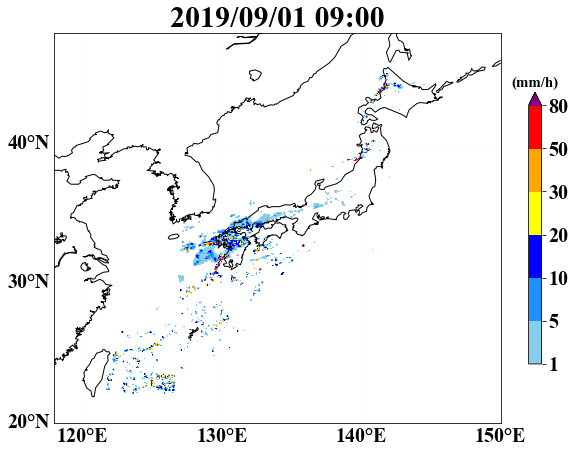

In [8]:
%matplotlib inline
plt.rc('font', **fonts)
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
mp.drawcoastlines(ax=ax)
mp.drawmeridians(np.arange(0., 361., 10.), labels=[True, False, False, True], linewidth=0.01, ax=ax)
mp.drawparallels(np.arange(-90., 91., 10.), labels=[True, False, False, True], linewidth=0.01, ax=ax) 
plot = ax.contourf(lon, lat, data, [1, 5, 10, 20, 30, 50, 80], colors=colors, extend="max")
cbar = fig.colorbar(plot, shrink=0.5)
cbar.ax.set_title("(mm/h)", fontsize=15)
ax.set_title('{0:04d}/{1:02d}/{2:02d} {3:02d}:00'.format(Y, M, D, H), fontsize=30)

plt.show()
plt.close('all')

最後にダウンロードしたファイルを消去します。

保存したままだとストレージを圧迫していきますからね。

最近のおすすめはpathlibライブラリを使用したデータ消去法です。

In [9]:
# delete file
tar.close()
Path(tar_file).unlink()

[ホームへ戻る](https://yellowmeteor.github.io/met_python.github.io/)